In [65]:
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings("ignore")

In [66]:
df = pd.read_csv('data/Tillit_Data.csv')
df.head()

,borrower_id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,outcome,purpose,addr_state,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,537185,16075.0,60 months,NaN,NaN,MORTGAGE,50289.0,Fully Paid,home_improvement,SC,...,0.0,2.0,95.7,100.0,0.0,0,227376.0,15756.0,11900.0,6000.0
1,1810804,8000.0,36 months,Graydon Head & Ritchey LLP,10+ years,MORTGAGE,64000.0,Fully Paid,debt_consolidation,IN,...,0.0,0.0,100.0,75.0,1.0,0,121881.0,33618.0,13700.0,29400.0
2,388855,23700.0,36 months,Director of IT,3 years,RENT,88000.0,Fully Paid,debt_consolidation,FL,...,0.0,5.0,100.0,10.0,1.0,0,99201.0,58898.0,18700.0,69501.0
3,1137067,1200.0,36 months,NaN,NaN,MORTGAGE,81000.0,Fully Paid,other,NY,...,0.0,4.0,83.3,100.0,0.0,0,203983.0,20609.0,1100.0,26183.0
4,14585,3500.0,36 months,NaN,NaN,RENT,11736.0,Fully Paid,debt_consolidation,WA,...,0.0,1.0,100.0,100.0,1.0,0,16200.0,9459.0,2000.0,0.0


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41029 entries, 0 to 41028
Data columns (total 78 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   borrower_id                     41029 non-null  int64  
 1   loan_amnt                       41006 non-null  float64
 2   term                            41029 non-null  object 
 3   emp_title                       36311 non-null  object 
 4   emp_length                      36628 non-null  object 
 5   home_ownership                  41029 non-null  object 
 6   annual_inc                      41029 non-null  float64
 7   outcome                         41029 non-null  object 
 8   purpose                         41029 non-null  object 
 9   addr_state                      41029 non-null  object 
 10  dti                             41029 non-null  float64
 11  delinq_2yrs                     41029 non-null  int64  
 12  earliest_cr_line                

In [68]:
df['annual_inc'].describe()

count    4.102900e+04
mean     8.008188e+04
std      6.165221e+04
min      2.500000e+03
25%      4.700000e+04
50%      6.738800e+04
75%      9.700000e+04
max      3.300000e+06
Name: annual_inc, dtype: float64

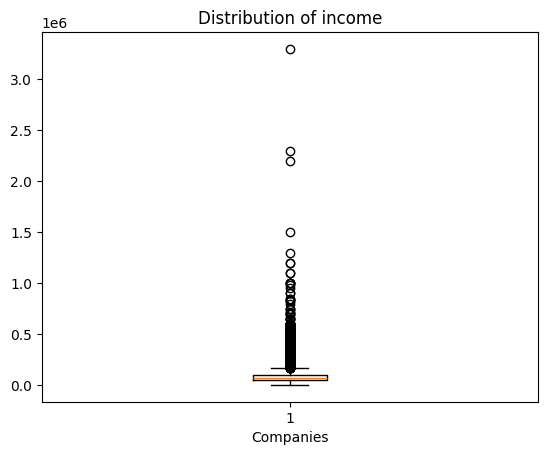

In [69]:
plt.boxplot(df['annual_inc'])
plt.xlabel('Companies')
plt.title('Distribution of income')
plt.show()

In [70]:
df[df['annual_inc'] >97000]['outcome'].value_counts()

outcome
Fully Paid    10042
Defaulted       182
Name: count, dtype: int64

We can see that the large values that may be seen as anomolies due to their size are valid points and most are also fully paid, thus we can proceed.

### Dealing with missing data

In [71]:
print(df.isna().sum().sort_values(ascending=False))
# Below we can see the number empty entries for the columns

mths_since_last_record         34213
mths_since_recent_bc_dlq       31574
mths_since_last_major_derog    30378
il_util                        29355
mths_since_rcnt_il             28014
                               ...  
collections_12_mths_ex_med         0
acc_now_delinq                     0
delinq_amnt                        0
chargeoff_within_12_mths           0
borrower_id                        0
Length: 78, dtype: int64


In [72]:
columns_to_drop = ['mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'il_util',
                   'mths_since_rcnt_il', 'mths_since_recent_revol_delinq', 'all_util', 'open_il_12m', 'open_acc_6m',
                   'open_act_il', 'total_cu_tl', 'open_il_24m', 'total_bal_il','open_rv_12m', 'open_rv_24m', 'max_bal_bc',
                   'inq_fi','inq_last_12m', 'mths_since_last_delinq'
                   ] # These columns have a large number of null values, so I have decided to drop the whole column

df.drop(columns = columns_to_drop, inplace=True)
df.dropna(inplace=True) # I have also dropped rows with null values, given more time I could have looked into estimating these values e.g. using mean, mode etc

In [73]:
df.shape
#around 13000 rows dropped from dataset

(27736, 59)

We can clearly see that we have a large number of columns so a correlation heatmap would not be suitable. Furthermore we have both numerical and categorical variables so need to apply ensemble techniques on the columns below so that they are in a suitable format for the modelling phase of this notebook.

-    term                            41029 non-null  object 
-    emp_title                       36311 non-null  object 
-    emp_length                      36628 non-null  object
-    home_ownership                  41029 non-null  object
-    purpose                         41029 non-null  object
-    addr_state                      41029 non-null  object 
-   earliest_cr_line                41029 non-null  object  

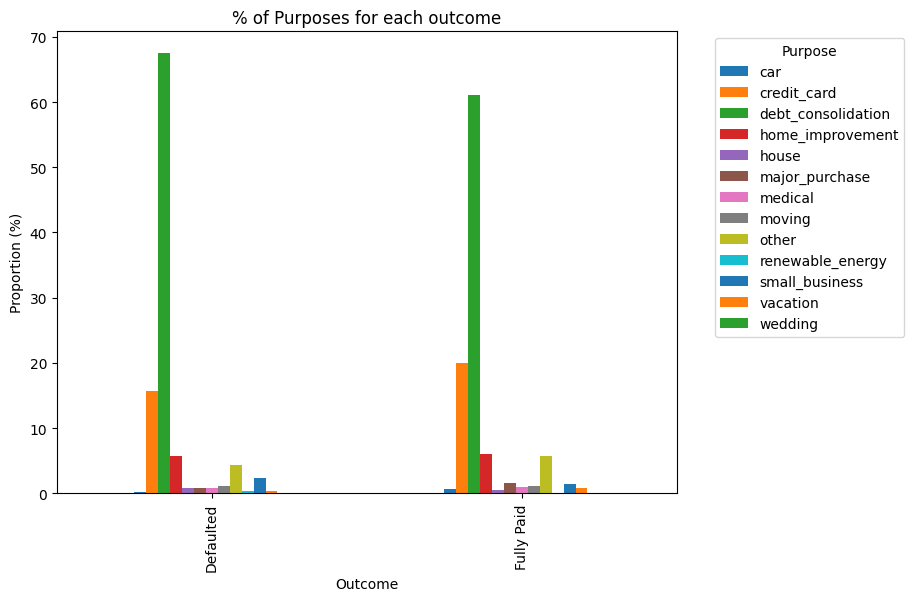

In [74]:
total = df['outcome'].value_counts() # We can see 1000 defaulted, may have some bias issues
grouped_data = df.groupby(['outcome', 'purpose']).size().unstack(fill_value=0)
grouped_data = grouped_data.div(total/100, axis=0)

# Plot the proportions
ax = grouped_data.plot(kind='bar', stacked=False, figsize=(8, 6))
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('Outcome')
ax.set_title('% of Purposes for each outcome')
ax.legend(title='Purpose', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

We can see that for the purpose, Debt consolidation and Credit card where the two most popular across both classes, followed by home improvement. As we don't want unnecessary features as this can lead to overfitting, we will combine other and the minority purposes into the the 'Other' class, and keep the top 3 as they are.

### Data cleaning and formatting

In [75]:
def emp_length_cleaner(x): # Function for formatting emp_length column
    if isinstance(x,str):
        if x[0:2] == '10':
            x = 10
        elif x[0:1] == '<':
            x = 1
        else:
            x = int(x.split()[0])
    return(x)

In [76]:
ownership_other = ['OTHER', 'ANY', 'NONE'] # Based on minority being any or None

purpose_other = ['other', 'moving', 'wedding', 'medical', # based on purpose being < 5 %
                 'major_purchase', 'car','small_business',
                 'house', 'vacation', 'renewable_energy',
                 'educational']

# Numerical element stripped from categorical columns 
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: int(x.split('-')[1]) if isinstance(x,str) else x)
df['term'] = df['term'].apply(lambda x: int(x.split()[0]) if isinstance(x,str) else x)
df['emp_length'] = df['emp_length'].apply(lambda x: emp_length_cleaner(x))

# Columns to one hot encode
df['home_ownership'] = df['home_ownership'].apply(lambda x: 'OTHER' if x in ownership_other else x)
df['purpose'] = df['purpose'].apply(lambda x : 'other' if x in purpose_other else x)

# Label encoded columns
label_encoder = LabelEncoder()
df['emp_title'] = label_encoder.fit(df['emp_title']).transform(df['emp_title'])
df['addr_state'] = label_encoder.fit(df['addr_state']).transform(df['addr_state'])

In [77]:
df['purpose'].value_counts() # We can see purpose only has 4 categories now

purpose
debt_consolidation    16972
credit_card            5525
other                  3576
home_improvement       1663
Name: count, dtype: int64

In [78]:
df_encoded = pd.get_dummies(df, columns=['home_ownership', 'purpose'])
df_encoded.set_index('borrower_id', inplace= True)
df_encoded.info()
# We have now retrieved transformed columns and can see the predictor variables are of type Integer or Float

<class 'pandas.core.frame.DataFrame'>
Index: 27736 entries, 1810804 to 1807816
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   27736 non-null  float64
 1   term                        27736 non-null  int64  
 2   emp_title                   27736 non-null  int64  
 3   emp_length                  27736 non-null  int64  
 4   annual_inc                  27736 non-null  float64
 5   outcome                     27736 non-null  object 
 6   addr_state                  27736 non-null  int64  
 7   dti                         27736 non-null  float64
 8   delinq_2yrs                 27736 non-null  int64  
 9   earliest_cr_line            27736 non-null  int64  
 10  inq_last_6mths              27736 non-null  int64  
 11  open_acc                    27736 non-null  int64  
 12  pub_rec                     27736 non-null  int64  
 13  revol_bal                   

In [79]:
df_encoded['outcome'].value_counts()

outcome
Fully Paid    27066
Defaulted       670
Name: count, dtype: int64

## Initial model buiding looking at Random Forest and Logistic Regression

In [80]:
X = df_encoded.drop('outcome', axis = 1)
y = df_encoded['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# We use stratify as the classes are imbalanced

In [81]:
# Due to the variances in the range of columns a standard scalar will help reduce bias when modelling.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest

In [82]:
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.98
Confusion Matrix:
[[   0  134]
 [   0 5414]]


The first thing we observe is the majority class is being predicted well, but the minority class not at all, let's try Logistic Regression

### Logistic Regression with L1 penalty

In [83]:
model1 = LogisticRegression(class_weight={'Defaulted' : 40, 'Fully Paid' : 1}, penalty='l1', solver = 'liblinear', C=0.001)
model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy1:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))
# print(model1.coef_[0])

Accuracy: 0.55
Confusion Matrix:
[[  89   45]
 [2444 2970]]


### Logistic Regression with L2 penalty

In [84]:
model2 = LogisticRegression(class_weight={'Defaulted' : 40, 'Fully Paid' : 1}, penalty = 'l2', solver='liblinear', C=0.001)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

accuracy2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy2:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))
# print(model2.coef_[0])

Accuracy: 0.63
Confusion Matrix:
[[  76   58]
 [2006 3408]]


### Logistic Regression with L1 and L2 penalty

In [85]:
model3 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio= 0.5, C=0.05)
model3.fit(X_train, y_train)

y_pred3 = model3.predict(X_test)

accuracy3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy: {accuracy3:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred3))

Accuracy: 0.98
Confusion Matrix:
[[   0  134]
 [   0 5414]]


## Attempt 2: Increasing weighting of Default class

### Random Forest

In [86]:
model = RandomForestClassifier(class_weight = {'Defaulted': 1000, 'Fully Paid' :1 })
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Accuracy: 0.98
Confusion Matrix:
[[   0  134]
 [   0 5414]]


### Logistic Regression

In [87]:
model2 = LogisticRegression(class_weight = {'Defaulted': 60, 'Fully Paid' :1 }, penalty='elasticnet', solver='saga', l1_ratio= 0.5, C=0.01)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

accuracy2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy2:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))

#print(model3.coef_[0])

Accuracy: 0.44
Confusion Matrix:
[[ 100   34]
 [3084 2330]]


We can see that adjusting the weighting did not help at all in Random Forest and for logistic regression whilst it did improve the accuracy of those defaulted it lead to a great loss in predicting those who fully paid correctly, so instead we will take random samples from the majority class (Fully paid) so it is equal to the minority class (Deafulted) so that we have a more balanced datatset.

## Attempt 3: Balancing classes

In [105]:
Fully_paid = df_encoded[df_encoded['outcome'] == 'Fully Paid']
Defaulted = df_encoded[df_encoded['outcome'] == 'Defaulted']

# Randomly sample from the majority class to match the size of the minority class
sampled_majority_class = Fully_paid.sample(n=len(Defaulted), random_state=42)

# Combine the sampled majority class with the minority class
balanced_df = pd.concat([sampled_majority_class, Defaulted], axis=0)

# Shuffle the rows to mix the classes
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
 
X = balanced_df.drop('outcome', axis=1) 
y = balanced_df['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest

In [107]:
model = RandomForestClassifier() 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Check feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = feature_importances.nlargest(n=15)

# print("Feature Importances:")
# print(top_features)

Accuracy: 0.61
Confusion Matrix:
[[79 55]
 [49 85]]


The Random forest is not predicting as accurately, however at least the Default values are being better predicted, let's now try logistic regression.

### Logistic Regression

In [108]:
model1 = LogisticRegression(penalty='l1', solver = 'liblinear', C=0.1)
model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy1:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))

Accuracy: 0.63
Confusion Matrix:
[[88 46]
 [53 81]]


In [111]:
# Logistic Regression model with L2
model2 = LogisticRegression(penalty = 'l2', solver='liblinear', C=0.05)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

accuracy2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy2:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))

Accuracy: 0.62
Confusion Matrix:
[[85 49]
 [54 80]]


### Logistic Regression with a L1 and L2 penalty

In [115]:
model_best = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio= 0.5, C=0.06) 
# both L1 and L2 has similar results so we set the ratio to 0.5 so both penalties have equal weighting

model_best.fit(X_train, y_train)
y_pred3_ = model_best.predict(X_test)

accuracy3_ = accuracy_score(y_test, y_pred3_)
print(f'Accuracy: {accuracy3_:.2f}')
print("Classification Report:")

print(classification_report(y_test, y_pred3_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred3_))

#print(model3.coef_[0])

Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

   Defaulted       0.63      0.66      0.64       134
  Fully Paid       0.64      0.62      0.63       134

    accuracy                           0.64       268
   macro avg       0.64      0.64      0.64       268
weighted avg       0.64      0.64      0.64       268

Confusion Matrix:
[[88 46]
 [51 83]]


### XGBoosting

In [94]:
label_mapping = {'Defaulted' : 1, 'Fully Paid' : 0}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

dtrain = xgb.DMatrix(X_train, label=y_train_mapped)
dtest = xgb.DMatrix(X_test, label=y_test_mapped)

# Specify parameters
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'eta': 0.3, 'max_depth': 4}

num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

y_pred = model.predict(dtest)
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred]

accuracy4 = accuracy_score(y_test_mapped, y_pred_binary)
print(f'Accuracy: {accuracy4:.2f}')
print(confusion_matrix(y_test_mapped, y_pred_binary))

Accuracy: 0.58
[[77 57]
 [56 78]]


so far the Logistic regression model seems to be performing best with both a L1 and L2 penalty, and a inverse of Regularisation of 0.06

Let us take the top most 15 features frm the above model. This may help reduce any overfitting and improve accuracy.

## Attempt 4: Using top 15 Features

In [116]:
top_features = pd.DataFrame(top_features)
top_features.reset_index(inplace=True)
top_features.columns = ['Feature', 'Importance']
subset = top_features['Feature'].tolist()

In [117]:
X = balanced_df.drop('outcome', axis=1) 
X = X[subset]
y = balanced_df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
X.head()

,loan_amnt,revol_util,emp_title,avg_cur_bal,dti,mo_sin_old_il_acct,bc_open_to_buy,revol_bal,tot_hi_cred_lim,mo_sin_old_rev_tl_op,total_bal_ex_mort,total_acc,total_rev_hi_lim,tot_cur_bal,total_bc_limit
0,25000.0,76.2,6347,35587.0,21.90,164.0,3082.0,44655,688337.0,373.0,257243.0,46,58600.0,640570.0,42800.0
1,12000.0,53.8,6738,11527.0,26.82,122.0,4253.0,17761,224567.0,124.0,58191.0,47,33000.0,195956.0,4800.0
2,20550.0,74.5,8034,48959.0,14.26,136.0,8758.0,25642,406021.0,196.0,41550.0,24,34400.0,391670.0,34400.0
3,5300.0,46.7,10363,6045.0,24.85,241.0,5441.0,4759,51899.0,180.0,36269.0,18,10200.0,36269.0,10200.0
4,17600.0,36.2,14002,4145.0,22.62,132.0,34642.0,25796,134536.0,155.0,34272.0,33,71200.0,78747.0,60400.0


In [119]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest

In [120]:
model = RandomForestClassifier() # adjusts for differet sized classes
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.53
Confusion Matrix:
[[79 55]
 [70 64]]


### Logistic Regression

In [121]:
model1 = LogisticRegression(penalty='l1', solver = 'liblinear', C=0.001)
model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_test)

accuracy1 = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy1:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))

# print(model1.coef_[0])

Accuracy: 0.55
Confusion Matrix:
[[86 48]
 [73 61]]


In [122]:
model2 = LogisticRegression(penalty = 'l2', solver='liblinear', C=0.001)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

accuracy2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy2:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))

Accuracy: 0.54
Confusion Matrix:
[[83 51]
 [73 61]]


### Logistic Regression with L1 and L2 penalty

In [123]:
model3 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio= 0.5, C=0.1)
model3.fit(X_train, y_train)

y_pred3 = model3.predict(X_test)

accuracy3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy: {accuracy3:.2f}')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred3))

Accuracy: 0.59
Confusion Matrix:
[[107  27]
 [ 84  50]]


### XGBoost

In [124]:
label_mapping = {'Defaulted' : 1, 'Fully Paid' : 0}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

dtrain = xgb.DMatrix(X_train, label=y_train_mapped)
dtest = xgb.DMatrix(X_test, label=y_test_mapped)

# Specify parameters
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'eta': 0.3, 'max_depth': 4}

# Train the model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)
y_pred = model.predict(dtest)

# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred]

# Evaluate accuracy
accuracy4 = accuracy_score(y_test_mapped, y_pred_binary)
print(f'Accuracy: {accuracy4:.2f}')
print(confusion_matrix(y_test_mapped, y_pred_binary))



Accuracy: 0.54
[[67 67]
 [57 77]]


# Conclusion

The Logistic regression model using L1 and L2 penalties performed the best amongst the 3 models. The penalties make insignificant features redundant and also reduces multicolinearity between features which is likely why it performed better with all of the features as opposed to just the top 15.

Further techniques can be used such as Cross validation, aswell as looking at other samples and an overall larger set of data, as well as putting the transformations and model into a pipeline for reproducability.
Below we have a confusion matrix of the best model.

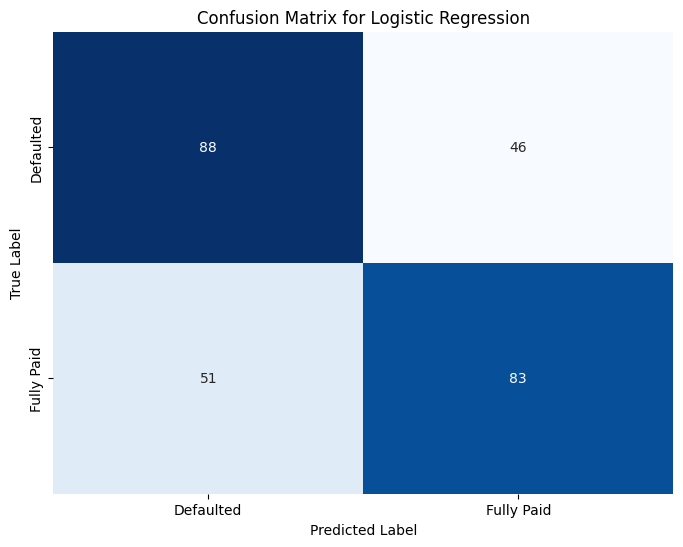

In [125]:
cm = confusion_matrix(y_test, y_pred3_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Defaulted', 'Fully Paid'],
            yticklabels=['Defaulted', 'Fully Paid'],)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()